# III. Custom ResNet50

In [35]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
#from google.colab import drive
from PIL import Image, ImageFile
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dropout
print(tf.__version__)
import PIL

import time
import numpy as np
import os
import pydot
from typing import List, Tuple
from matplotlib.pyplot import imshow
%matplotlib inline
import matplotlib.pyplot as plt
import PIL.Image
import pathlib
import shutil

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model

from tensorflow.python.keras.utils import layer_utils
#from tensorflow.keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications.imagenet_utils import preprocess_input

from IPython.display import SVG

import scipy.misc

import tensorflow.keras.backend as K
K.set_image_data_format('channels_last') # can be channels_first or channels_last.
#K.set_learning_phase(1) # 1 stands for learning phase

2.16.1


## 1. Data Preprocessing 
**224*224, RGB**

In [36]:
#drive.mount('/content/drive')

# List contents of Google Drive root directory
folder_path = '/Users/mingentsai/Desktop/USC/Courses/DSO 569/Homework/Group Project/Bone_Fracture_Binary_Classification'
contents = os.listdir(folder_path)
print(contents)

['.DS_Store', 'test', 'train', 'val']


In [74]:
ImageFile.LOAD_TRUNCATED_IMAGES = True # Allow loading of truncated images

def load_images_from_folder(base_folder):
  data = []
  labels = []
  categories = {'fractured': 1, 'not fractured': 0}
  for category, label in categories.items():
    folder_path = os.path.join(base_folder, category)
    if os.path.isdir(folder_path):
      for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpeg', '.jpg')): # Handle both .jpeg and .jpg fi
          img_path = os.path.join(folder_path, filename)
          try:
            with Image.open(img_path) as img:
              img = img.convert('RGB')
              img = img.resize((224, 224),PIL.Image.Resampling.LANCZOS)
              data.append(np.array(img))
              labels.append(label)
          except IOError as e:
            print(f"Error opening or processing image {img_path}: {e}")
        else:
          print(f"Skipped non-JPEG file {filename}")
    else:
      print(f"Directory {folder_path} does not exist")

  # Convert to numpy arrays
  data = np.array(data)
  labels = np.array(labels)

  # Shuffle the data
  idx = np.arange(len(data))
  np.random.shuffle(idx)
  data = data[idx]
  labels = labels[idx]

  return data, labels

In [75]:
train_data, train_labels = load_images_from_folder(os.path.join(folder_path, 'train'))
val_data, val_labels = load_images_from_folder(os.path.join(folder_path, 'val'))
test_data, test_labels = load_images_from_folder(os.path.join(folder_path, 'test'))

Skipped non-JPEG file .DS_Store
Skipped non-JPEG file .DS_Store
Skipped non-JPEG file .DS_Store
Skipped non-JPEG file .DS_Store
Skipped non-JPEG file .DS_Store


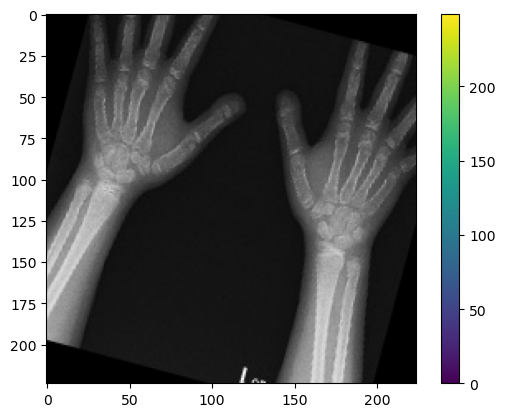

In [76]:
plt.figure()
plt.imshow(train_data[1])
plt.colorbar()
plt.grid(False)
plt.show()

In [77]:
# normalize to range 0-1
train_images = train_data / 255.0
test_images = test_data / 255.0
val_images = val_data / 255.0

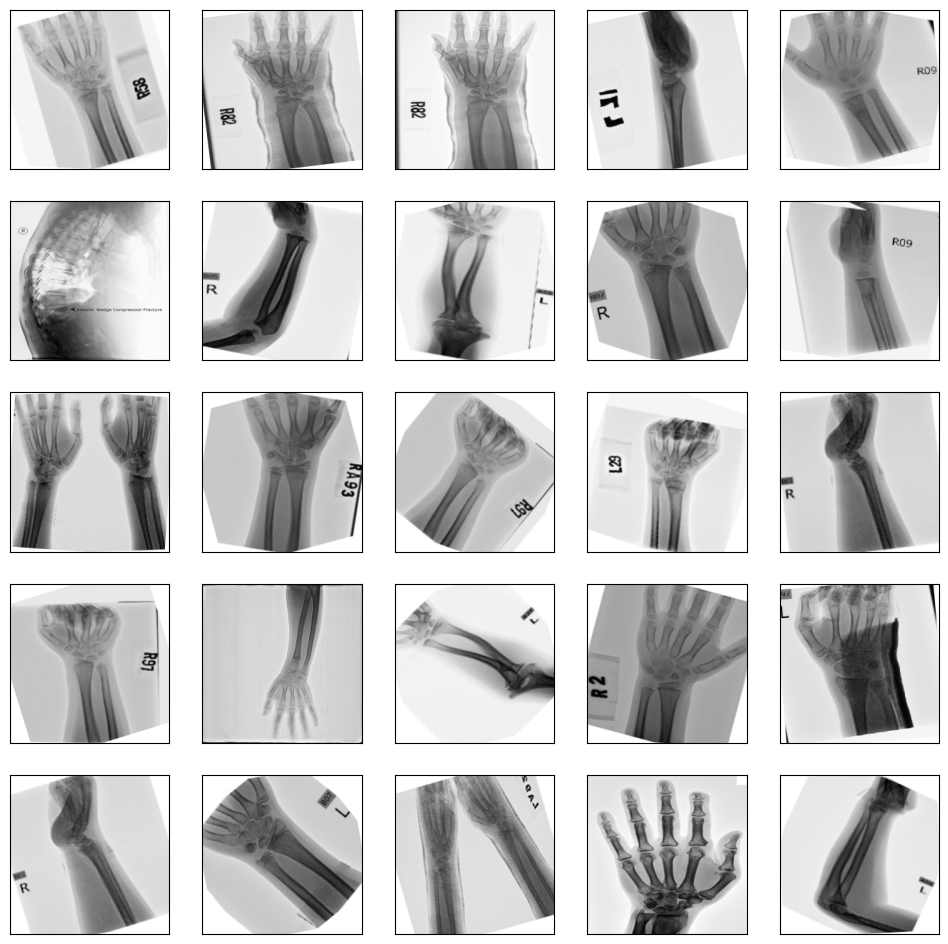

In [78]:
plt.figure(figsize=(12,12))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train[i], cmap=plt.cm.binary)
plt.show()

In [80]:
train_images.shape

(9200, 224, 224, 3)

In [81]:
from tensorflow.keras.utils import to_categorical

# Assuming you have two classes, and train_labels are integer labels like [0, 1]
train_labels= to_categorical(train_labels, num_classes=2)
test_labels= to_categorical(test_labels, num_classes=2)
val_labels= to_categorical(val_labels, num_classes=2)

In [102]:
train_labels[:20]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]])

In [103]:
val_labels[:20]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.]])

## 2. Model fitting

In [88]:
def identity_block(X: tf.Tensor, level: int, block: int, filters: list[int]) -> tf.Tensor:
    """
    Creates an identity block (see figure 3.1 from readme)

    Input:
        X - input tensor of shape (m, height_prev, width_prev, chan_prev)
        level - integer, one of the 5 levels that our networks is conceptually divided into (see figure 3.1 in the readme file)
              - level names have the form: conv2_x, conv3_x ... conv5_x
        block - each conceptual level has multiple blocks (1 identity and several convolutional blocks)
                block is the number of this block within its conceptual layer
                i.e. first block from level 2 will be named conv2_1
        filters - a list on integers, each of them defining the number of filters in each convolutional layer

    Output:
        X - tensor (m, height, width, chan)
    """

    # layers will be called conv{level}_iden{block}_{convlayer_number_within_block}'
    conv_name = f'conv{level}_{block}' + '_{layer}_{type}'

    # unpack number of filters to be used for each conv layer
    f1, f2, f3 = filters

    # the shortcut branch of the identity block
    # takes the value of the block input
    X_shortcut = X

    # first convolutional layer (plus batch norm & relu activation, of course)
    X = Conv2D(filters=f1, kernel_size=(1, 1), strides=(1, 1),
               padding='valid', name=conv_name.format(layer=1, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=1, type='bn'))(X)
    X = Activation('relu', name=conv_name.format(layer=1, type='relu'))(X)

    # second convolutional layer
    X = Conv2D(filters=f2, kernel_size=(3, 3), strides=(1, 1),
               padding='same', name=conv_name.format(layer=2, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=2, type='bn'))(X)
    X = Activation('relu')(X)

    # third convolutional layer
    X = Conv2D(filters=f3, kernel_size=(1, 1), strides=(1, 1),
               padding='valid', name=conv_name.format(layer=3, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=3, type='bn'))(X)

    # add shortcut branch to main path
    X = Add()([X, X_shortcut])

    # relu activation at the end of the block
    X = Activation('relu', name=conv_name.format(layer=3, type='relu'))(X)

    return X


In [89]:
def convolutional_block(X: tf.Tensor, level: int, block: int, filters: list[int], s: tuple[int,int,int]=(2, 2)) -> tf.Tensor:
    """
    Creates a convolutional block (see figure 3.1 from readme)

    Input:
        X - input tensor of shape (m, height_prev, width_prev, chan_prev)
        level - integer, one of the 5 levels that our networks is conceptually divided into (see figure 3.1 in the readme file)
              - level names have the form: conv2_x, conv3_x ... conv5_x
        block - each conceptual level has multiple blocks (1 identity and several convolutional blocks)
                block is the number of this block within its conceptual layer
                i.e. first block from level 2 will be named conv2_1
        filters - a list on integers, each of them defining the number of filters in each convolutional layer
        s   - stride of the first layer;
            - a conv layer with a filter that has a stride of 2 will reduce the width and height of its input by half

    Output:
        X - tensor (m, height, width, chan)
    """

    # layers will be called conv{level}_{block}_{convlayer_number_within_block}'
    conv_name = f'conv{level}_{block}' + '_{layer}_{type}'

    # unpack number of filters to be used for each conv layer
    f1, f2, f3 = filters

    # the shortcut branch of the convolutional block
    X_shortcut = X

    # first convolutional layer
    X = Conv2D(filters=f1, kernel_size=(1, 1), strides=s, padding='valid',
               name=conv_name.format(layer=1, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=1, type='bn'))(X)
    X = Activation('relu', name=conv_name.format(layer=1, type='relu'))(X)

    # second convolutional layer
    X = Conv2D(filters=f2, kernel_size=(3, 3), strides=(1, 1), padding='same',
               name=conv_name.format(layer=2, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=2, type='bn'))(X)
    X = Activation('relu', name=conv_name.format(layer=2, type='relu'))(X)

    # third convolutional layer
    X = Conv2D(filters=f3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name.format(layer=3, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=3, type='bn'))(X)

    # shortcut path
    X_shortcut = Conv2D(filters=f3, kernel_size=(1, 1), strides=s, padding='valid',
                        name=conv_name.format(layer='short', type='conv'),
                        kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=conv_name.format(layer='short', type='bn'))(X_shortcut)

    # add shortcut branch to main path
    X = Add()([X, X_shortcut])

    # nonlinearity
    X = Activation('relu', name=conv_name.format(layer=3, type='relu'))(X)

    return X

In [92]:
def ResNet50(input_size: tuple[int,int,int], classes: int) -> Model:
    """
        Builds the ResNet50 model (see figure 4.2 from readme)

        Input:
            - input_size - a (height, width, chan) tuple, the shape of the input images
            - classes - number of classes the model must learn

        Output:
            model - a Keras Model() instance
    """

    # tensor placeholder for the model's input
    X_input = Input(input_size)

    ### Level 1 ###

    # padding
    X = ZeroPadding2D((3, 3))(X_input)

    # convolutional layer, followed by batch normalization and relu activation
    X = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2),
               name='conv1_1_1_conv',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='conv1_1_1_nb')(X)
    X = Activation('relu')(X)

    ### Level 2 ###

    # max pooling layer to halve the size coming from the previous layer
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # 1x convolutional block
    X = convolutional_block(X, level=2, block=1, filters=[64, 64, 256], s=(1, 1))

    # 2x identity blocks
    X = identity_block(X, level=2, block=2, filters=[64, 64, 256])
    X = identity_block(X, level=2, block=3, filters=[64, 64, 256])

    ### Level 3 ###

    # 1x convolutional block
    X = convolutional_block(X, level=3, block=1, filters=[128, 128, 512], s=(2, 2))

    # 3x identity blocks
    X = identity_block(X, level=3, block=2, filters=[128, 128, 512])
    X = identity_block(X, level=3, block=3, filters=[128, 128, 512])
    X = identity_block(X, level=3, block=4, filters=[128, 128, 512])

    ### Level 4 ###
    # 1x convolutional block
    X = convolutional_block(X, level=4, block=1, filters=[256, 256, 1024], s=(2, 2))
    # 5x identity blocks
    X = identity_block(X, level=4, block=2, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=3, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=4, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=5, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=6, filters=[256, 256, 1024])

    ### Level 5 ###
    # 1x convolutional block
    X = convolutional_block(X, level=5, block=1, filters=[512, 512, 2048], s=(2, 2))
    # 2x identity blocks
    X = identity_block(X, level=5, block=2, filters=[512, 512, 2048])
    X = identity_block(X, level=5, block=3, filters=[512, 512, 2048])

    # Pooling layers
    X = AveragePooling2D(pool_size=(2, 2), name='avg_pool')(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc_' + str(classes),
              kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [91]:
image_size = (224, 224)
channels = 3
num_classes = 2

In [93]:
model = ResNet50(input_size = (image_size[1], image_size[0], channels), classes = num_classes)

In [94]:
model.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_4    │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_1_1_conv      │ (None, 112, 112,  │      9,472 │ zero_padding2d_4… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_1_1_nb        │ (None, 112, 112,  │        256 │ conv1_1_1_conv[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_52       │ (None, 112, 112,  │          0 │ conv1_1_1_nb[0][… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 55, 55,    │          0 │ activation_52[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1_1_conv      │ (None, 55, 55,    │      4,160 │ max_pooling2d_4[… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1_1_bn        │ (None, 55, 55,    │        256 │ conv2_1_1_conv[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1_1_relu      │ (None, 55, 55,    │          0 │ conv2_1_1_bn[0][… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1_2_conv      │ (None, 55, 55,    │     36,928 │ conv2_1_1_relu[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1_2_bn        │ (None, 55, 55,    │        256 │ conv2_1_2_conv[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1_2_relu      │ (None, 55, 55,    │          0 │ conv2_1_2_bn[0][… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1_3_conv      │ (None, 55, 55,    │     16,640 │ conv2_1_2_relu[0… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1_short_conv  │ (None, 55, 55,    │     16,640 │ max_pooling2d_4[… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1_3_bn        │ (None, 55, 55,    │      1,024 │ conv2_1_3_conv[0… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1_short_bn    │ (None, 55, 55,    │      1,024 │ conv2_1_short_co… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_64 (Add)        │ (None, 55, 55,    │          0 │ conv2_1_3_bn[0][

 Total params: 23,624,578 (90.12 MB)

 Trainable params: 23,571,458 (89.92 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [95]:
model.compile(
    optimizer='adam', # optimizer
    loss='categorical_crossentropy', # loss function to optimize
    metrics=['accuracy'] # metrics to monitor
)

In [96]:
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Validation images shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)

Train images shape: (9200, 224, 224, 3)
Train labels shape: (9200, 2)
Validation images shape: (827, 224, 224, 3)
Validation labels shape: (827, 2)


In [97]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=2,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath="checkpoint_path.keras",
        monitor="val_accuracy",
        save_best_only=True,
    )
]



history = model.fit(train_images,  train_labels, epochs=100,
          batch_size=64, validation_data=(val_images, val_labels),
          callbacks=callbacks_list)

Epoch 1/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 816s 6s/step - accuracy: 0.6599 - loss: 1.9708 - val_accuracy: 0.6179 - val_loss: 0.7685
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 809s 6s/step - accuracy: 0.9193 - loss: 0.2482 - val_accuracy: 0.6264 - val_loss: 281.7943
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 805s 6s/step - accuracy: 0.9233 - loss: 0.6854 - val_accuracy: 0.6239 - val_loss: 1.7360
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 955s 7s/step - accuracy: 0.9640 - loss: 0.1195 - val_accuracy: 0.8017 - val_loss: 0.7777
Epoch 5/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 816s 6s/step - accuracy: 0.9816 - loss: 0.0519 - val_accuracy: 0.9238 - val_loss: 0.3030
Epoch 6/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 818s 6s/step - accuracy: 0.9954 - loss: 0.0202 - val_accuracy: 0.9262 - val_loss: 0.2753
Epoch 7/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 832s 6s/step - accuracy: 0.8946 - loss: 0.4906 - val_accuracy: 0.7848 - val_loss: 0.8124
Epoch 8/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 807s 6s/step - accuracy: 0.9882 - loss: 0.0440 

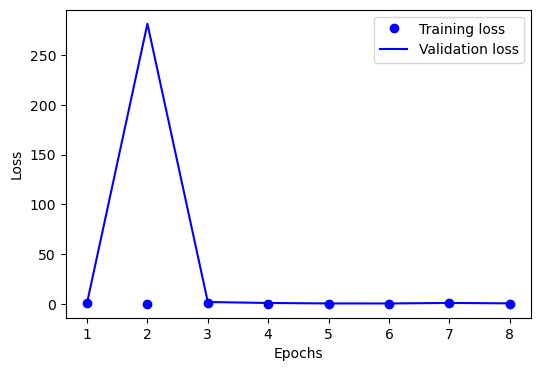

In [98]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
# Set up the range of epochs
epochs = range(1, len(loss_values) + 1)
# Create a plot of the training and validation loss
plt.figure(figsize=(6, 4))
plt.plot(epochs, loss_values, 'bo', label='Training loss') # 'bo' for blue dot
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') # 'b' for solid blue line plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [101]:
model_best = keras.models.load_model("checkpoint_path.keras")
test_loss, test_acc = model_best.evaluate(test_images, test_labels)
print("Test accuracy:", test_acc)

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 580ms/step - accuracy: 0.9199 - loss: 0.2041
Test accuracy: 0.9226069450378418
